# TableTwo Creation

## 0. Libraries

In [1]:
import pandas as pd
from tableone import TableOne
import matplotlib.pyplot as plt
import openpyxl

## 1. Load Data

In [2]:
df = pd.read_pickle("./data/patient_imputed_cleaned.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37274 entries, 0 to 49968
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         37274 non-null  object        
 1   sex                        37274 non-null  category      
 2   age                        37274 non-null  int64         
 3   num_shots                  37274 non-null  int64         
 4   type_center                37274 non-null  category      
 5   vaccinated                 37274 non-null  category      
 6   icu                        37274 non-null  category      
 7   inpatient_days             37274 non-null  int64         
 8   admission_datetime         37274 non-null  datetime64[ns]
 9   discharge_datetime         37274 non-null  datetime64[ns]
 10  hospital_outcome           37274 non-null  category      
 11  death_datetime             7202 non-null   datetime64[ns]
 12  followup_

Keep the interest columns.

In [3]:
keep_columns = [col for col in df.columns if col.startswith('wave')]
keep_columns = keep_columns + ["vaccinated", "hospital_outcome"]
df = df[keep_columns]
df[keep_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 37274 entries, 0 to 49968
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   wave_3            37274 non-null  category
 1   wave_4            37274 non-null  category
 2   wave_5            37274 non-null  category
 3   wave_6            37274 non-null  category
 4   wave_7            37274 non-null  category
 5   vaccinated        37274 non-null  category
 6   hospital_outcome  37274 non-null  category
dtypes: category(7)
memory usage: 546.1 KB


## 2. Mortality per wave

Let's create a categorical variable to summary all the wave information (and use it as stratifier).

In [4]:
waves_columns = [col for col in df.columns if col.startswith('wave')]
df['waves_cat'] = df[waves_columns].idxmax(axis=1)

In [5]:
df.head()

,wave_3,wave_4,wave_5,wave_6,wave_7,vaccinated,hospital_outcome,waves_cat
0,0,0,1,0,0,0,0,wave_5
1,0,0,0,1,0,1,0,wave_6
2,1,0,0,0,0,0,0,wave_3
3,0,1,0,0,0,0,0,wave_4
4,0,1,0,0,0,0,0,wave_4


Rename the levels to replace "_" by whitespace

In [6]:
df['waves_cat'] = df['waves_cat'].replace(to_replace=r'wave_(\d+)', value=r'Wave \1', regex=True)
df['waves_cat'].head()

0    Wave 5
1    Wave 6
2    Wave 3
3    Wave 4
4    Wave 4
Name: waves_cat, dtype: object

Configure the table

In [7]:
columns = ['hospital_outcome', 'waves_cat']
groupby = ["waves_cat"]
labels = {'waves_cat': 'Waves',
          'hospital_outcome': 'Mortality'}

df["hospital_outcome"] = df["hospital_outcome"].map({0:"Survivor", 1:"Deceased"})

Render the table

In [8]:
table_mortality_waves = TableOne(df,
                                 columns=columns,
                                 groupby=groupby,
                                 rename=labels)

table_mortality_waves

Grouped by Waves                                                                               
                                   Missing       Overall       Wave 3       Wave 4       Wave 5       Wave 6       Wave 7
n                                                  37274        11873         7053         5090         6951         6307
Mortality, n (%) Deceased                0   7202 (19.3)  2700 (22.7)    648 (9.2)   817 (16.1)  1628 (23.4)  1409 (22.3)
                 Survivor                   30072 (80.7)  9173 (77.3)  6405 (90.8)  4273 (83.9)  5323 (76.6)  4898 (77.7)

Let save as HTML

In [9]:
save_path = "./TableMortality_Waves.html"

# # # # # # # # # # # # # # # # # # # # # # # # # # # 
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <head><title>HTML Pandas Dataframe with CSS</title></head>
  <link rel="stylesheet" type="text/css" href="df_style.css"/>
  <body>
    {table}
  </body>
</html>
'''

# OUTPUT AN HTML FILE
with open(save_path, 'w') as f:
    f.write(html_string.format(table=table_mortality_waves.to_html(classes='mystyle')))

Let save as excel

In [10]:
excel_path = "../OUTPUT_figures_tables/Table_2_MortalityPerWaves.xlsx"
table_mortality_waves.to_excel(excel_path, sheet_name="Sheet1")

In [11]:
wb = openpyxl.load_workbook(excel_path)
sheet = wb["Sheet1"]
# Clean format
for row in sheet.iter_rows():
    for cell in row:
        cell.font = openpyxl.styles.Font()
        cell.border = openpyxl.styles.Border()
        cell.fill = openpyxl.styles.fills.PatternFill()

abc = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
body_cols_letters = list(abc[2:table_mortality_waves.tableone.shape[1]+2])
last_col = body_cols_letters[-1]

# Width Columns
sheet.column_dimensions['A'].width = 20
sheet.column_dimensions['B'].width = 15
for i in body_cols_letters:
    sheet.column_dimensions[i].width = 12

# Align text to center in colum C
for row in sheet.iter_rows(min_row=5, min_col=3, max_col=3):
    for cell in row:
        cell.alignment = openpyxl.styles.Alignment(horizontal='center')

# Align text to center in row 4
for row in sheet.iter_rows(min_row=4, max_row=4, min_col=4, max_col=6):
    for cell in row:
        cell.alignment = openpyxl.styles.Alignment(horizontal='center')

# colors
color_green1 = openpyxl.styles.colors.Color(rgb='007932')
color_green2 = openpyxl.styles.colors.Color(rgb='368f3f')
color_green3 = openpyxl.styles.colors.Color(rgb='54995E')
color_white = openpyxl.styles.colors.Color(rgb='ffffff')
color_gray1 = openpyxl.styles.colors.Color(rgb='c9c9c9')

# Edit header
header_cell = sheet['C1']
sheet.row_dimensions[1].height=35
header_cell.alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')
header_cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=color_green1)
header_cell.font = openpyxl.styles.Font(name="SourceSansPro", size=15, bold=True, color=color_white)


# Edit subheader cells
sheet.row_dimensions[2].height=20
for row in sheet[f'C2:{last_col}2']:
    for cell in row:
        cell.alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')
        cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=color_green2)
        cell.font = openpyxl.styles.Font(name="SourceSansPro", size=12, bold=True, color=color_white)

## Add subheader for variables
sheet.row_dimensions[3].height=20
sheet['A3'] = 'Variable'
sheet['B3'] = 'Level'
for row in sheet[f'A3:{last_col}3']:
    for cell in row:
        cell.alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')
        cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=color_green2)
        cell.font = openpyxl.styles.Font(name="SourceSansPro", size=12, color=color_white)

sheet.row_dimensions[4].height=20
for row in sheet[f'A4:{last_col}4']:
    for cell in row:
        cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=color_green3)
        cell.font = openpyxl.styles.Font(name="SourceSansPro", size=10, color=color_white)
        cell.alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')

# Edit variables rows (alterning row color)
cells_vars = []
for row in sheet[f'A5:A{sheet.max_row}']:
    for cell in row:
        if not isinstance(cell, openpyxl.cell.cell.MergedCell):
            cells_vars.append(cell)
for i, cell in enumerate(cells_vars):
    if i % 2 == 0:
        for row in sheet[f'A{cell.row}:{last_col}{cell.row}']:
            for cell in row:
                cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=color_gray1)

#Set font all table_body
for row in sheet[f'A5:{last_col}{sheet.max_row}']:
    for cell in row:
        cell.font = openpyxl.styles.Font(name="SourceSansPro", size=10)

# Border 
border1 = openpyxl.styles.Border(bottom=openpyxl.styles.Side(border_style='thin', color='000000'))
side =openpyxl.styles.Side(border_style='thin', color='000000')


# Body borders
cells_vars = [row[0] for row in sheet[f'A5:A{sheet.max_row}']]
for i, cell in enumerate(cells_vars):
    if isinstance(cell, openpyxl.cell.cell.MergedCell):
        cells_vars[i-1]=None
cells_vars = [cell for cell in cells_vars if cell is not None]

for cell in cells_vars:
    i = cell.row
    for row in sheet[f'A{i}:{last_col}{i}']:
        for cell in row:
            cell.border = border1

# header border
for row in sheet[f'A4:{last_col}4']:
    for cell in row:
        cell.border = border1

# Vertical border middle
for row in sheet[f'B3:B{sheet.max_row}']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=prev_border.left,
                                            right=side,
                                            top=prev_border.top,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border


#Outborder left
for row in sheet[f'A3:A{sheet.max_row}']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=side,
                                            right=prev_border.right,
                                            top=prev_border.top,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border

#Outborder bottom
for row in sheet[f'A{sheet.max_row}:{last_col}{sheet.max_row}']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=prev_border.left,
                                            right=prev_border.right,
                                            top=prev_border.top,
                                            bottom=side)
        
        cell.border = new_border

#Outborder right
for row in sheet[f'{last_col}{sheet.min_row}:{last_col}{sheet.max_row}']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=prev_border.left,
                                            right=side,
                                            top=prev_border.top,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border        

#Outborder header
for row in sheet[f'C1:{last_col}1']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=prev_border.left,
                                            right=prev_border.right,
                                            top=side,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border
for row in sheet['C1:C2']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=side,
                                            right=prev_border.right,
                                            top=prev_border.top,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border 
for row in sheet['A3:B3']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=prev_border.top,
                                            right=prev_border.right,
                                            top=side,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border 

wb.save(excel_path)

Let's plot the mortality per wave

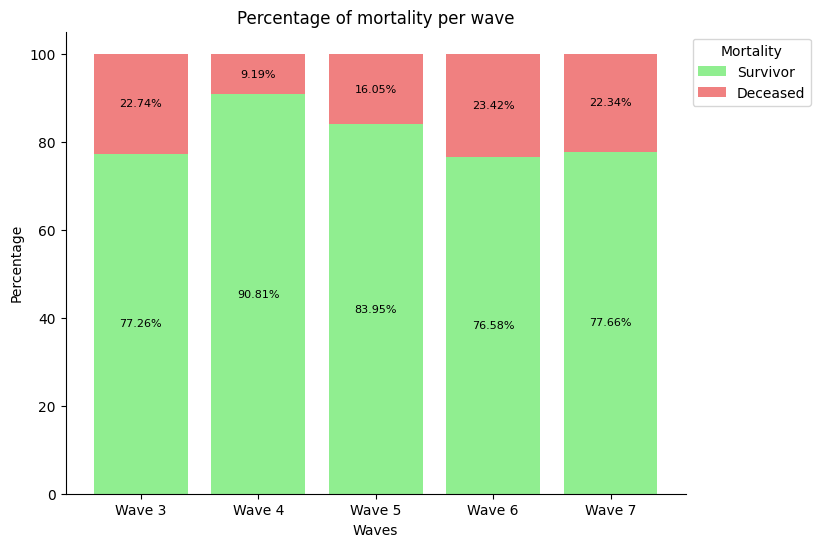

In [12]:
total_wave = df["waves_cat"].value_counts(sort=False)

values = df[["hospital_outcome", "waves_cat"]].value_counts(sort=False)


##### PREPARE THE DATA #########
#Die
values_died = values["Deceased"]
for wave_name in total_wave.sort_index().index.tolist():
    if wave_name not in values_died.index:
        values_died[wave_name] = 0
values_died = values_died.sort_index()
bar_died = [round(values_died[wave]*100/total_wave[wave], 3) for wave in values_died.index]
#Survive
values_survived = values["Survivor"]
for wave_name in total_wave.sort_index().index:
    if wave_name not in values_survived.index.tolist():
        values_survived[wave_name] = 0
values_survived = values_survived.sort_index()
bar_survive = [round(values_survived[wave]*100/total_wave[wave], 3) for wave in values_died.index]


waves = [f"Wave {i[-1]}" for i in sorted(total_wave.index.to_list())]
##### PLOT #########
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(waves, bar_survive, color='lightgreen', label="Survivor")
ax.bar(waves, bar_died, bottom=bar_survive, color='lightcoral', label="Deceased")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Percentage of mortality per wave")
bar_survive = [round(values_survived[wave]*100/total_wave[wave], 3) for wave in values_survived.index]
ax.set_ylabel("Percentage")
ax.set_xlabel("Waves")

# Add a legend
plt.legend(title = "Mortality", loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Add text with percentages
for i, (idx, val_died, val_surv) in enumerate(zip(waves, bar_died, bar_survive)):
    per_died = str(round(val_died, 2)) + "%"
    ax.text(i, bar_survive[i] + bar_died[i]/2, per_died, ha="center", va="center", fontsize=8)

    per_surv = str(round(val_surv, 2)) + "%"
    ax.text(i, bar_survive[i]/2, per_surv, ha="center", va="center", fontsize=8)

save_path = "../OUTPUT_figures_tables/Figure_5"
fig.savefig(save_path+".tiff", bbox_inches='tight')
fig.savefig(save_path+".png", bbox_inches='tight')

plt.show()

## 2. Admission of vaccinated people per wave

In [13]:
columns = ['vaccinated', 'waves_cat']
groupby = ["waves_cat"]
labels = {'waves_cat': 'Waves',
          'vaccinated': 'Vaccinated'}

df["vaccinated"] = df["vaccinated"].map({0:"No vaccinated", 1:"Vaccinated"})

Render the table

In [14]:
table_vaccines_waves = TableOne(df,
                                 columns=columns,
                                 groupby=groupby,
                                 labels=labels)

table_vaccines_waves

/home/juanluisgonzalez/FPS_proyects/Vacc_analisys/.venv/lib64/python3.9/site-packages/tableone/tableone.py:226: DeprecationWarning: The labels argument is deprecated; use rename instead.
  warnings.warn("The labels argument is deprecated; use "


Grouped by Waves                                                                                
                                    Missing         Overall        Wave 3       Wave 4       Wave 5       Wave 6       Wave 7   
n                                                        37274         11873         7053         5090         6951         6307
Vaccinated, n (%) No vaccinated         0         22724 (61.0)  11695 (98.5)  6372 (90.3)  2688 (52.8)  1547 (22.3)    422 (6.7)
                  Vaccinated                      14550 (39.0)     178 (1.5)    681 (9.7)  2402 (47.2)  5404 (77.7)  5885 (93.3)

Let save as HTML

In [15]:
save_path = "./TableVaccinesAdmisions_Waves.html"

# # # # # # # # # # # # # # # # # # # # # # # # # # # 
pd.set_option('colheader_justify', 'center')   # FOR TABLE <th>

html_string = '''
<html>
  <head><title>HTML Pandas Dataframe with CSS</title></head>
  <link rel="stylesheet" type="text/css" href="df_style.css"/>
  <body>
    {table}
  </body>
</html>
'''

# OUTPUT AN HTML FILE
with open(save_path, 'w') as f:
    f.write(html_string.format(table=table_vaccines_waves.to_html(classes='mystyle')))

Let's save as excel

In [16]:
excel_path = "../OUTPUT_figures_tables/Table_3_VaccinatedPerWaves.xlsx"
table_vaccines_waves.to_excel(excel_path, sheet_name="Sheet1")

In [17]:
wb = openpyxl.load_workbook(excel_path)
sheet = wb["Sheet1"]
# Clean format
for row in sheet.iter_rows():
    for cell in row:
        cell.font = openpyxl.styles.Font()
        cell.border = openpyxl.styles.Border()
        cell.fill = openpyxl.styles.fills.PatternFill()

abc = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
body_cols_letters = list(abc[2:table_vaccines_waves.tableone.shape[1]+2])
last_col = body_cols_letters[-1]

# Width Columns
sheet.column_dimensions['A'].width = 20
sheet.column_dimensions['B'].width = 15
for i in body_cols_letters:
    sheet.column_dimensions[i].width = 12

# Align text to center in colum C
for row in sheet.iter_rows(min_row=5, min_col=3, max_col=3):
    for cell in row:
        cell.alignment = openpyxl.styles.Alignment(horizontal='center')

# Align text to center in row 4
for row in sheet.iter_rows(min_row=4, max_row=4, min_col=4, max_col=6):
    for cell in row:
        cell.alignment = openpyxl.styles.Alignment(horizontal='center')

# colors
color_green1 = openpyxl.styles.colors.Color(rgb='007932')
color_green2 = openpyxl.styles.colors.Color(rgb='368f3f')
color_green3 = openpyxl.styles.colors.Color(rgb='54995E')
color_white = openpyxl.styles.colors.Color(rgb='ffffff')
color_gray1 = openpyxl.styles.colors.Color(rgb='c9c9c9')

# Edit header
header_cell = sheet['C1']
sheet.row_dimensions[1].height=35
header_cell.alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')
header_cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=color_green1)
header_cell.font = openpyxl.styles.Font(name="SourceSansPro", size=15, bold=True, color=color_white)


# Edit subheader cells
sheet.row_dimensions[2].height=20
for row in sheet[f'C2:{last_col}2']:
    for cell in row:
        cell.alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')
        cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=color_green2)
        cell.font = openpyxl.styles.Font(name="SourceSansPro", size=12, bold=True, color=color_white)

## Add subheader for variables
sheet.row_dimensions[3].height=20
sheet['A3'] = 'Variable'
sheet['B3'] = 'Level'
for row in sheet[f'A3:{last_col}3']:
    for cell in row:
        cell.alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')
        cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=color_green2)
        cell.font = openpyxl.styles.Font(name="SourceSansPro", size=12, color=color_white)

sheet.row_dimensions[4].height=20
for row in sheet[f'A4:{last_col}4']:
    for cell in row:
        cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=color_green3)
        cell.font = openpyxl.styles.Font(name="SourceSansPro", size=10, color=color_white)
        cell.alignment = openpyxl.styles.Alignment(horizontal='center', vertical='center')

# Edit variables rows (alterning row color)
cells_vars = []
for row in sheet[f'A5:A{sheet.max_row}']:
    for cell in row:
        if not isinstance(cell, openpyxl.cell.cell.MergedCell):
            cells_vars.append(cell)
for i, cell in enumerate(cells_vars):
    if i % 2 == 0:
        for row in sheet[f'A{cell.row}:{last_col}{cell.row}']:
            for cell in row:
                cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=color_gray1)

#Set font all table_body
for row in sheet[f'A5:{last_col}{sheet.max_row}']:
    for cell in row:
        cell.font = openpyxl.styles.Font(name="SourceSansPro", size=10)

# Border 
border1 = openpyxl.styles.Border(bottom=openpyxl.styles.Side(border_style='thin', color='000000'))
side =openpyxl.styles.Side(border_style='thin', color='000000')


# Body borders
cells_vars = [row[0] for row in sheet[f'A5:A{sheet.max_row}']]
for i, cell in enumerate(cells_vars):
    if isinstance(cell, openpyxl.cell.cell.MergedCell):
        cells_vars[i-1]=None
cells_vars = [cell for cell in cells_vars if cell is not None]

for cell in cells_vars:
    i = cell.row
    for row in sheet[f'A{i}:{last_col}{i}']:
        for cell in row:
            cell.border = border1

# header border
for row in sheet[f'A4:{last_col}4']:
    for cell in row:
        cell.border = border1

# Vertical border middle
for row in sheet[f'B3:B{sheet.max_row}']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=prev_border.left,
                                            right=side,
                                            top=prev_border.top,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border


#Outborder left
for row in sheet[f'A3:A{sheet.max_row}']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=side,
                                            right=prev_border.right,
                                            top=prev_border.top,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border

#Outborder bottom
for row in sheet[f'A{sheet.max_row}:{last_col}{sheet.max_row}']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=prev_border.left,
                                            right=prev_border.right,
                                            top=prev_border.top,
                                            bottom=side)
        
        cell.border = new_border

#Outborder right
for row in sheet[f'{last_col}{sheet.min_row}:{last_col}{sheet.max_row}']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=prev_border.left,
                                            right=side,
                                            top=prev_border.top,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border        

#Outborder header
for row in sheet[f'C1:{last_col}1']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=prev_border.left,
                                            right=prev_border.right,
                                            top=side,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border
for row in sheet['C1:C2']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=side,
                                            right=prev_border.right,
                                            top=prev_border.top,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border 
for row in sheet['A3:B3']:
    for cell in row:
        prev_border = cell.border

        new_border = openpyxl.styles.Border(left=prev_border.top,
                                            right=prev_border.right,
                                            top=side,
                                            bottom=prev_border.bottom)
        
        cell.border = new_border 

wb.save(excel_path)

Let's plot the admission of vaccinated and no vaccionated people per wave.

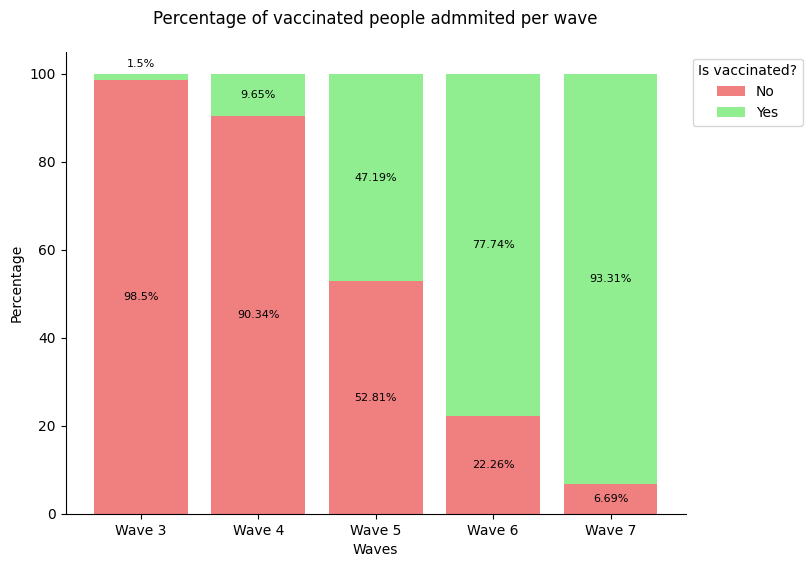

In [18]:
total_wave = df["waves_cat"].value_counts(sort=False)
values = df[["vaccinated", "waves_cat"]].value_counts(sort=False)

values_no_vaccinated = values["No vaccinated"]
values_vaccinated = values["Vaccinated"]

for wave in df["waves_cat"].unique():
    if wave not in values_vaccinated:
        values_vaccinated[wave] = 0
    if wave not in values_no_vaccinated:
        values_no_vaccinated[wave] = 0
values_no_vaccinated = values_no_vaccinated.reindex(sorted(total_wave.index.to_list()))
values_vaccinated = values_vaccinated.reindex(sorted(total_wave.index.to_list()))

##### PREPARE THE DATA #########
#No Vaccinated
bar_novaccinated= [round(values_no_vaccinated[wave]*100/total_wave[wave], 3) for wave in values_no_vaccinated.index]
#Vaccinated
bar_vaccinated= [round(values_vaccinated[wave]*100/total_wave[wave], 3) for wave in values_vaccinated.index]

waves = [f"Wave {i[-1]}" for i in sorted(total_wave.index.to_list())]
######## PLOT #########
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(waves, bar_novaccinated, color='lightcoral', label="No")
ax.bar(waves, bar_vaccinated, bottom=bar_novaccinated, color='lightgreen', label="Yes")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Percentage of vaccinated people admmited per wave", pad = 20)
ax.set_ylabel("Percentage")
ax.set_xlabel("Waves")

# Add a legend
plt.legend(title = "Is vaccinated?", loc='upper left', bbox_to_anchor=(1,1), ncol=1)


# Add text with percentages
for i, (idx, val_no_vacc, val_vacc) in enumerate(zip(waves, bar_novaccinated, bar_vaccinated)):
    per_no_vacc = str(round(val_no_vacc, 2)) + "%"
    ax.text(i, bar_novaccinated[i]/2, per_no_vacc, ha="center", va="center", fontsize=8)

    if round(val_vacc, 2) == 0:
        pass
    if 0 < round(val_vacc, 2) <= 5 :
        per_vacc = str(round(val_vacc, 2)) + "%"
        ax.text(i, bar_novaccinated[i] + bar_vaccinated[i]/2 + 3, per_vacc, ha="center", va="center", fontsize=8)
    elif round(val_vacc, 2) > 5: 
        per_vacc = str(round(val_vacc, 2)) + "%"
        ax.text(i, bar_novaccinated[i] + bar_vaccinated[i]/2, per_vacc, ha="center", va="center", fontsize=8)

save_path = "../OUTPUT_figures_tables/Figure_6"
fig.savefig(save_path+".tiff", bbox_inches='tight')
fig.savefig(save_path+".png", bbox_inches='tight')

#plot
plt.show()